In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.under_sampling import RandomUnderSampler
import sklearn as sk
import pickle

In [2]:
def df_transformation(df):
    df_temp = df[features]
    df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

    output = df_temp.groupby(by=["datetime"], dropna=False).mean().reset_index()
    
    return output 

In [3]:
# Create a custom function for data transformation
# May as well import all of these features into the initial dataframe, you can cut it down..
# ..when you do the X,y train/test split
features = ['datetime',
            'latitude',
            'longitude',
            'absoluteAltitude',
            'magneticHeading',
            'trueHeading',
            'groundSpeed',
            'trueAirspeed',
            'pitch',
            'roll',
            'yaw',
            'angleOfAttack',
            'flightPathAngle',
            'verticalFlightPathAngle',
            'horizontalFlightPathAngle',
            'rollAcceleration',
            'pitchAcceleration',
            'yawAcceleration',
            'e1N1ng',
            'e2N1ng',
            'e1N2nf',
            'e2N2nf',
            'mainRotorRpm',
            'tailRotorRpm',
            'mainRotorTorque',
            'e1Itt',
            'e2Itt',
            'mainRotorInducedInflow',
            'flightDirectorPitch',
            'flightDirectorRoll',
            'climbOrDescentRate',
            'hasWeightOnWheels',
            'turnRate to degPerSec',
            'cyclicPositionPitch',
            'cyclicPositionRoll',
            'collectivePosition',
            'antiTorquePedalPosition',
            'throttlePosition',
            'e1Torque',
            'e2Torque'
           ]

In [4]:
# reading files from 9/19 dataset
df1 = pd.read_csv('SimData_2022.09.19_16.00.36.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df1 = df_transformation(df1)


df2 = pd.read_csv('SimData_2022.09.19_16.38.20.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df2 = df_transformation(df2)


df3 = pd.read_csv('SimData_2022.09.19_17.51.37.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df3 = df_transformation(df3)



# reading files from 9/20 dataset
df4 = pd.read_csv('SimData_2022.09.20_16.22.07.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df4 = df_transformation(df4)


df5 = pd.read_csv('SimData_2022.09.20_16.28.31.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df5 = df_transformation(df5)


# reading file from 9/22 dataset
df6 = pd.read_csv('SimData_2022.09.22_17.11.56.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df6 = df_transformation(df6)


# reading file from 10/06 dataset
df7 = pd.read_csv('SimData_2022.10.06_09.47.22.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df7 = df_transformation(df7)

In [5]:
#Combine files
df = pd.concat([df1, df2, df3, df4, df5, df6, df7]).reset_index()
len(df)

363330

# Quick Stop - DataFrame Labelling

In [6]:
df_q = df.copy()
df_q['quickstop'] = 0

df_q.loc[(df_q['datetime'].between('2022-09-19 22:00:35' , '2022-09-19 22:01:44' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-09-19 22:11:55' , '2022-09-19 22:13:21' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-09-22 21:36:50' , '2022-09-22 21:37:10' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-09-22 21:39:16' , '2022-09-22 21:39:42' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-09-22 21:40:06' , '2022-09-22 21:40:36' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-10-06 13:51:17' , '2022-10-06 13:51:42' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-10-06 14:04:58' , '2022-10-06 14:05:25' , inclusive='both')),['quickstop']] = 1
df_q.loc[(df_q['datetime'].between('2022-10-06 14:06:03' , '2022-10-06 14:06:20' , inclusive='both')),['quickstop']] = 1

In [7]:
#orginal class imbalance
df_q['quickstop'].value_counts()

0    350090
1     13240
Name: quickstop, dtype: int64

# Quick Stop - Model Features and Class Balance

In [8]:
#call features used in model
model_features = ['hasWeightOnWheels',
                  'absoluteAltitude',
                  'groundSpeed',
                  'climbOrDescentRate',
                  'cyclicPositionPitch',
                  'cyclicPositionRoll',
                  'collectivePosition',
                  'antiTorquePedalPosition',
                  'throttlePosition',
                  'e1Torque',
                  'e2Torque'
                 ]

In [9]:
#call OverSampler using 'majority' 
rus = RandomUnderSampler(sampling_strategy='majority')

In [10]:
#set x and y to respective features
quickstop_x, quickstop_y = df_q[model_features], df_q['quickstop']

In [11]:
#resample
quickstop_x, quickstop_y = rus.fit_resample(quickstop_x, quickstop_y)

In [12]:
#new class balance
quickstop_y.value_counts()

0    13240
1    13240
Name: quickstop, dtype: int64

# Quick Stop - XGBoost Model

In [13]:
#train and test split for model
quickstop_x_train, quickstop_x_test, quickstop_y_train, quickstop_y_test = sk.model_selection.train_test_split(quickstop_x,quickstop_y,test_size=0.05,random_state=777)

In [14]:
#call XG Boost model and fit to data
quickstop_model = XGBClassifier(use_label_encoder=False, max_depth = 4, eta = .075)
quickstop_model.fit(quickstop_x_train, quickstop_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.075,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.075000003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [15]:
#training model prediction
quickstop_train_pred = quickstop_model.predict(quickstop_x_train)

In [16]:
#test model prediction
quickstop_pred = quickstop_model.predict(quickstop_x_test)

In [17]:
#accuracy scores
quickstop_train_acc = sk.metrics.accuracy_score(quickstop_y_train, quickstop_train_pred)
quickstop_test_acc = sk.metrics.accuracy_score(quickstop_y_test, quickstop_pred)

In [18]:
print("Train Accuracy: %.2f%%" % (quickstop_train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (quickstop_test_acc * 100.0))

Train Accuracy: 96.96%
Test Accuracy: 96.90%


In [19]:
#auc roc scores
quickstop_train_roc = sk.metrics.roc_auc_score(quickstop_y_train, quickstop_train_pred)
quickstop_test_roc = sk.metrics.roc_auc_score(quickstop_y_test, quickstop_pred)

In [20]:
print("Train ROC AUC Score: %.2f%%" % (quickstop_train_roc * 100.0))
print("Test ROC AUC Score: %.2f%%" % (quickstop_test_roc * 100.0))

Train ROC AUC Score: 96.96%
Test ROC AUC Score: 96.88%


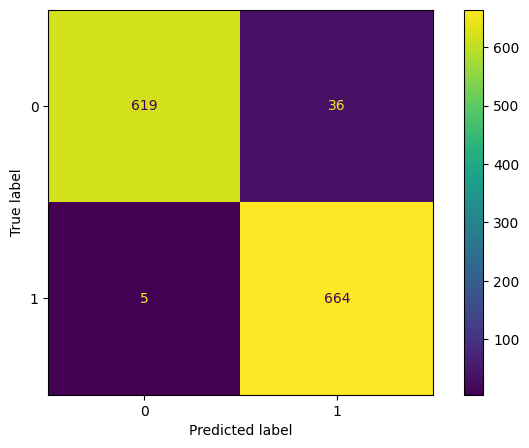

In [21]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(quickstop_y_test, quickstop_pred),)
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


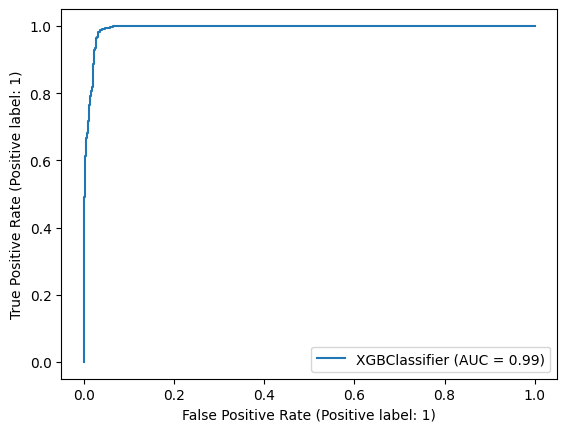

In [22]:
#auc roc plot
sk.metrics.plot_roc_curve(quickstop_model, quickstop_x_test, quickstop_y_test)
plt.show()

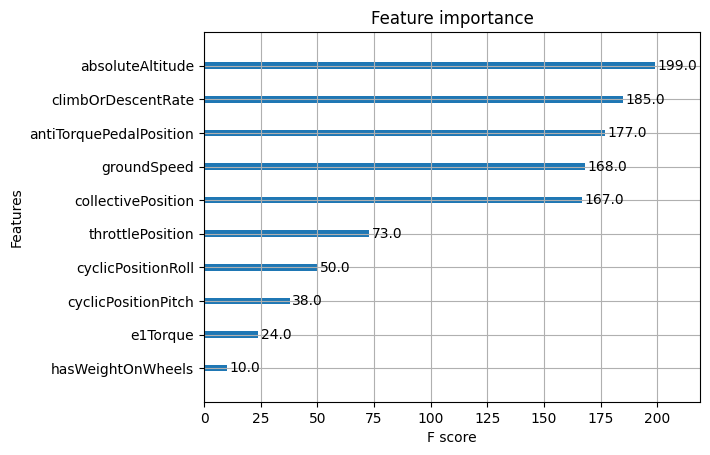

In [23]:
plot_importance(quickstop_model)
plt.show()

In [24]:
filename = 'final_qs_model.sav'
pickle.dump(quickstop_model, open(filename, 'wb'))